In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mude_tools import magicplotter
%matplotlib widget

## Introduction

As seen in the previous notebook, the least squares apporach can lead to severe over-fitting if complex models are trained on small data-sets. Our strategie of limiting the number of basis functions a priori to counter the over-fitting puts us at risk of missing important trends in the data. Another way to control the model flexibility is the introduction of a regularization term. This additional term prevents the weights from taking too large values, unless supported by the data. The concept of regularized least squares will be demonstrated on the usual sine function.

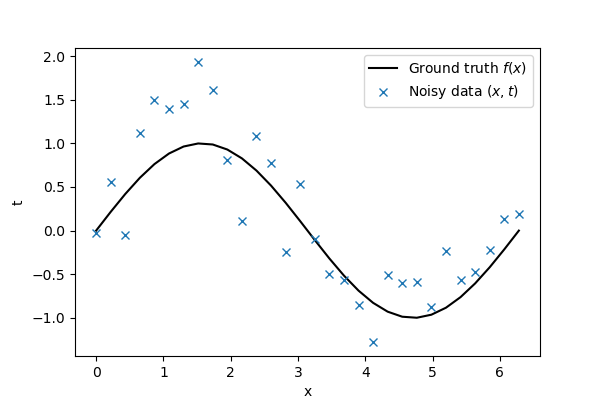

In [2]:
# The true function relating t to x
def f_truth(x, freq=1, **kwargs):
    
    # Return a sine with a frequency of f
    return np.sin(x * freq)

# The data generation function
def f_data(epsilon=0.5, N=30, **kwargs):

    # Apply a seed if one is given
    if 'seed' in kwargs:
        np.random.seed(kwargs['seed'])

    # Get the minimum and maximum
    xmin = kwargs.get('xmin', 0)
    xmax = kwargs.get('xmax', 2*np.pi)
    
    # Generate N evenly spaced observation locations
    x = np.linspace(xmin, xmax, N)
    
    # Generate N noisy observations (1 at each location)
    t = f_truth(x, **kwargs) + np.random.normal(0, epsilon, N)
    
    # Return both the locations and the observations
    return x, t

# Get the observed data
# x, t = f_data(xmin = -1, xmax = 1)
x, t = f_data()

# Plot the data and the ground truth
plt.figure(figsize=(6,4))

plt.plot(x, f_truth(x), 'k-', label=r'Ground truth $f(x)$')
plt.plot(x, t, 'x', label=r'Noisy data $(x,t)$')
plt.xlabel('x')
plt.ylabel('t')
plt.legend()

plt.show()

## Regularized least squares

We extend the data-dependent error $E_D(\bf{w})$ with the regularization term $E_W(\bf{w})$:

$$
E (\mathbf{w}) = E_D (\mathbf{w}) + \lambda E_W (\mathbf{w})
$$

with regularization parameter $\lambda$ that controls the relative importance of two terms comprising the error function. A common choice for the regularizer is the sum-of-squares:

$$
E_W(\mathbf{w}) = \frac{1}{2} \mathbf{w}^T \mathbf{w}.
$$

The resulting model is known as L2 regularization, Ridge regression, or weight decay. The total error therefore becomes

$$
E (\mathbf{w}) = \frac{1}{2} \sum_{n = 1}^{N} \left( t_n - \mathbf{w}^T \boldsymbol{\phi} (x_n) \right)^2 + \frac{\lambda}{2} \mathbf{w}^T \mathbf{w}.
$$

<!-- Taking its gradient gives

$$
\nabla_{\mathbf{w}} E_{\mathcal{D}} = \frac{1}{N} \sum_{n=1}^N \big(t_n - \mathbf{w}^T \mathbf{x}_n \big) \mathbf{x}_n
$$ -->

A useful property of the L2 regularization is that the error functions is still a quadratic function, allowing for a closed form solution for its minimizer. Setting the gradient of the regularized error function with respect to $\mathbf{w}$ to $0$ gives

$$
\bar{\mathbf{w}} = \big( \boldsymbol{\Phi}^T \boldsymbol{\Phi} + \lambda \mathbf{I} \big)^{-1} \boldsymbol{\Phi}^T \mathbf{t}.
$$

<!-- Keeping in mind that $\boldsymbol{\Phi}^T \boldsymbol{\Phi}$ is a positive semi-definite matrix, the eigenvalues of the inverse of $\boldsymbol{\Phi}^T \boldsymbol{\Phi} + \lambda \mathbf{I}$ will shrink with an inceasing $\lambda$, therefore pulling the weights towards $0$ compared to the unregularized solution. -->

Optimizing for both $\mathbf{w}$ and $\lambda$ over the training data-set leads to the trivial solution $\lambda = 0$ and therefore to the unregularized least squares problem. 

## Determining the regularization parameter

The problem of controlling the model complexity has been shifted from choosing a suitable set of basis functions to determining the regularization parameter $\lambda$. Optimizing for both $\mathbf{w}$ and $\lambda$ over the training data-set will favour flexibility of the models and leads to the trivial solution $\lambda = 0$ and therefore to the unregularized least squares problem. A better apporach is to partition the data into a training set and a validation set. The trainig set is used to determine the parameters $\mathbf{w}$, and the validation set to optimize the model complexity.

In [3]:
# Now we need a generic function that solves the least squares problem for us
def solve_reg_least_squares(X, t, phi, lam):
    """
    Arguments:
    X   -  The observed inputs (1D array)
    t   -  The observed targets (1D array)
    phi -  The basis functions.
    """
    
    Phi = phi(X)
    t = t.reshape(-1,1)
    I = np.identity(Phi.shape[1])
    I[0,0] = 0.0
    
    return np.linalg.solve( Phi.T @ Phi + lam * I, Phi.T @ t)

In [4]:
# Here is a function for the polynomial basis functions:
def PolynomialBasis(x, degree, **kwargs):  #**kwargs):
    """
    A function that computes polynomial basis functions.
    
    Arguments:
    x       -  The datapoints
    degree  -  The degree of the polynomial
    """
    return np.array([x ** i for i in range(degree + 1)]).transpose()

In [5]:
# Define the prediction locations
# (note that these are different from the locations where we observed our data)
x_pred = np.linspace(-1 -np.pi, np.pi+1, 1000)

# Define a function that makes a prediction at the given locations, based on the given (x,t) data
def predict(x, t, x_pred, basis, lam, **kwargs):
    
    # Get the variable matrix using the basis function phi
    Phi = basis(x, **kwargs)
    
    I = np.identity(Phi.shape[1])
    I[0,0] = 0.0
    
    # Get the coefficient vector
    w = np.linalg.solve( Phi.T @ Phi + lam * I, Phi.T @ t)
    # print(w)
    
    # Make a prediction in the prediction locations
    Phi_pred = basis(x_pred, **kwargs)
    y_pred = Phi_pred @ w
    
    # Return the predicted values
    return y_pred

/home/leon/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.72854e-25): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


(-1.5, 1.5)

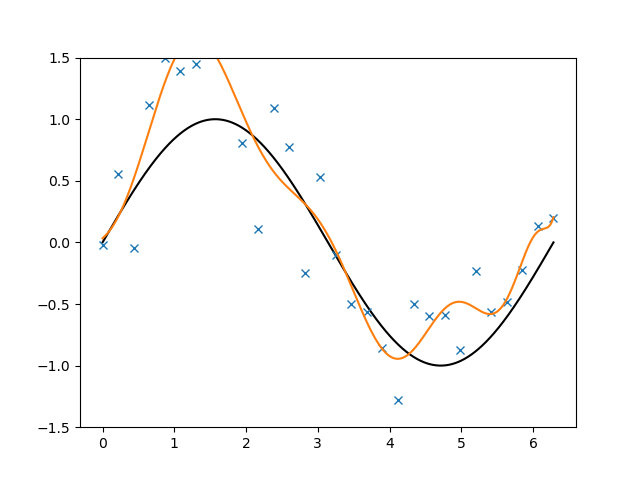

In [6]:
x_train = x.reshape(-1,1)
y_train = t.reshape(-1,1)
rng = np.random.RandomState(0)
x_plot = np.linspace(0, 2*np.pi, 1000).reshape(-1,1)
# x_plot = np.linspace(-1, 1, 1000).reshape(-1,1)

model = make_pipeline(PolynomialFeatures(14), Ridge(alpha=1e-2))
model.fit(x_train, y_train)
y_plot = model.predict(x_plot)

fig, ax = plt.subplots()
ax.plot(x_plot, f_truth(x_plot), 'k-', label=r'Ground truth $f(x)$')
ax.plot(x_train, y_train, 'x')
ax.plot(x_plot, y_plot)
ax.set_ylim(-1.5,1.5)

In [7]:
# Define the prediction locations
# (note that these are different from the locations where we observed our data)
x_pred = np.linspace(-1 -np.pi, np.pi+1, 1000)

# Define a function that makes a prediction at the given locations, based on the given (x,t) data
def predict1(x, t, x_pred, basis, lam, **kwargs):
    
    # Get the variable matrix using the basis function phi
    Phi = basis(x.reshape(-1), **kwargs)
    t = t.reshape(-1)
    x_pred = x_pred.reshape(-1)
    
    I = np.identity(Phi.shape[1])
    I[0,0] = 0.0
    
    # Get the coefficient vector
    w = np.linalg.solve( Phi.T @ Phi + lam * I, Phi.T @ t)
    # print(w)
    
    # Make a prediction in the prediction locations
    Phi_pred = basis(x_pred, **kwargs)
    y_pred = Phi_pred @ w
    
    # Return the predicted values
    return y_pred

(-1.5, 1.5)

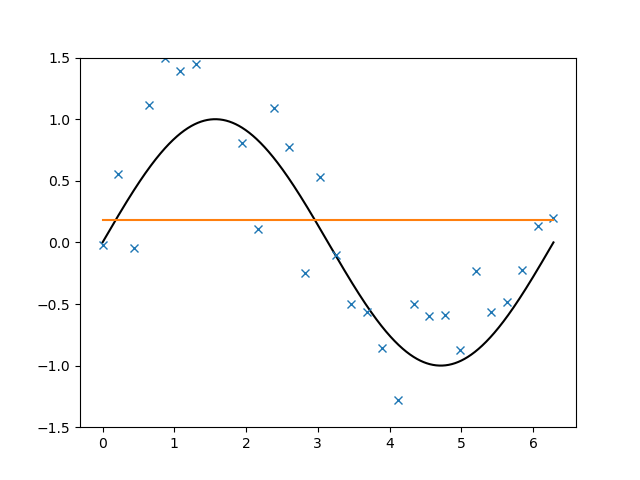

In [8]:
xscaler, tscaler = StandardScaler(), StandardScaler()
x_sc, t_sc = xscaler.fit_transform(x[:,None]), tscaler.fit_transform(t[:,None])

# Ntrain = int(0,7*len(x))
# x_train, x_val, t_train, t_val = train_test_split(x, t, train_size=Ntrain)

x_plot = np.linspace(0, 2*np.pi, 1000)[:,None]


t_plot = tscaler.inverse_transform(predict1(x_sc, t_sc, xscaler.transform(x_plot),
                                            PolynomialBasis, degree=4, lam=1e8)[:,None])


fig, ax = plt.subplots()
ax.plot(x_plot, f_truth(x_plot), 'k-', label=r'Ground truth $f(x)$')
ax.plot(x, t, 'x')
ax.plot(x_plot, t_plot)
ax.set_ylim(-1.5,1.5)

Best fit for lambda = 3.360606  with MSE = 0.244912


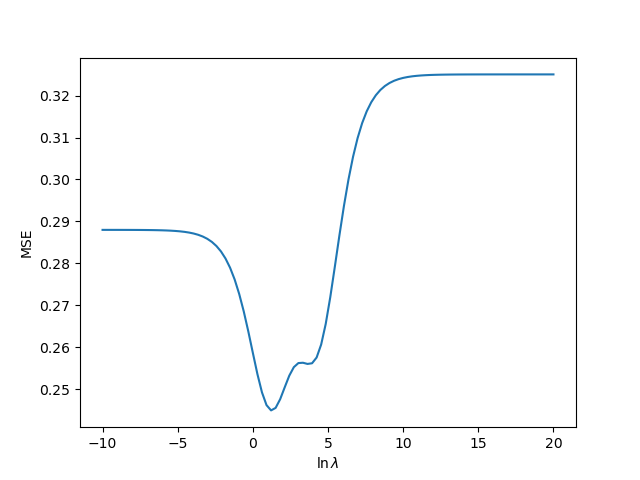

In [42]:
xscaler, tscaler = StandardScaler(), StandardScaler()
x_sc, t_sc = xscaler.fit_transform(x[:,None]), tscaler.fit_transform(t[:,None])

np.random.seed(0)
Ntrain = int(0.7*len(x))
x_train, x_val, t_train, t_val = train_test_split(x_sc, t_sc, train_size=Ntrain)

alphas = np.linspace(-10,20,100)
# alphas = np.linspace(0,1,2)
mse_val = np.zeros_like(alphas)
x_plot = np.linspace(0, 2*np.pi, 1000)[:,None]

    
for i, alpha in enumerate(alphas):
    
    t_pred = tscaler.inverse_transform(predict1(x_train, t_train, x_val, PolynomialBasis, degree=4, lam=np.exp(alpha))[:,None])
    
    
    mse_val[i] =sum((tscaler.inverse_transform(t_val) - t_pred)**2) / len(x_val)
    
    # t_plot = tscaler.inverse_transform(predict1(x_train, t_train, xscaler.transform(x_plot),
    #                                             PolynomialBasis, degree=4, lam=np.exp(alpha))[:,None])
    
    # fig, ax = plt.subplots()
    # ax.plot(x_plot, f_truth(x_plot), 'k-', label=r'Ground truth $f(x)$')
    # ax.plot(x_plot, t_plot)
    # ax.plot(xscaler.inverse_transform(x_train), tscaler.inverse_transform(t_train), 'x')
    # ax.plot(xscaler.inverse_transform(x_val), tscaler.inverse_transform(t_val), 'x')
    # ax.plot(xscaler.inverse_transform(x_val), t_pred, 'x')
    
    
    # print(t_pred)
    # print(tscaler.inverse_transform(t_val))
    # print("Val error: {}".format(mse_val[i]))

loc = np.argmin(mse_val)
alpha_min = alphas[loc]
mse_min = mse_val[loc]

print("Best fit for lambda = {:4f}  with MSE = {:4f}".format(np.exp(alpha_min), mse_min))
    
fig, ax = plt.subplots()
ax.plot(alphas, mse_val)
ax.set_xlabel(r'$\mathrm{ln}\,\lambda$')
ax.set_ylabel(r'MSE')

plt.show()


# fig, ax = plt.subplots()
# ax.plot(x_train, t_train, 'x')
# ax.plot(x_val, t_val, 'x')

In [ ]:
# Let's take a look at our regularized solution
plot = magicplotter(f_data, f_truth, predict1, x_pred, basis=PolynomialBasis, degree = 9,
                    lam = np.exp(alpha_min), xmin=-np.pi, xmax=np.pi, N=20, pred_label='Prediction $y(x)$')
plot.show()

We obtain the linear model with nonlinear basis functions by replacing the coordinate vector $x$ with the  feature vector $\boldsymbol{\phi}(x)$

$$ y(x,\mathbf{w}) = \sum_{j=0}^M w_j \phi_j(x) = \mathbf{w}^T \boldsymbol{\phi} (x).$$

The solution procedure remains the same, and we can solve for $\bar{\mathbf{w}}$ directly

$$ \bar{\mathbf{w}} = \big( \boldsymbol{\Phi}^T \boldsymbol{\Phi} \big)^{-1} \boldsymbol{\Phi}^T \mathbf{t}.$$

Let's take a look at the linear model with polynomial regressors.

In [ ]:
# Plot the resulting predictions
fig, ax = plt.subplots(2, 2, figsize=(9,6), sharex='all', sharey='all') 
plt.suptitle(r'generalized linear regression for polynomials of degree $p$')

# Plot for degree=2
magicplotter(f_data, f_truth, predict, x_pred, basis=PolynomialBasis, degree = 15, lam = 1e-1,
             xmin=-np.pi, xmax=np.pi, ax=ax[0][0], pred_label='Prediction $y(x)$', title=r'$degree={degree}$')

# Plot for degree=5
# magicplotter(f_data, f_truth, predict, x_pred, basis=PolynomialBasis, degree=5, ax=ax[0][1], hide_legend=True, title=r'$degree={degree}$')
magicplotter(f_data, f_truth, predict, x_pred, basis=PolynomialBasis, degree = 15, lam = 1e2,
             xmin=-np.pi, xmax=np.pi, ax=ax[0][1], pred_label='Prediction $y(x)$')

# Plot for degree=10
magicplotter(f_data, f_truth, predict, x_pred, basis=PolynomialBasis, degree = 15, lam = 1e5,
             xmin=-np.pi, xmax=np.pi, ax=ax[1][0], pred_label='Prediction $y(x)$')

# Plot for degree=24
magicplotter(f_data, f_truth, predict, x_pred, basis=PolynomialBasis, degree = 15, lam = 1e8,
             xmin=-np.pi, xmax=np.pi, ax=ax[1][1], pred_label='Prediction $y(x)$')

# Add a general legend at the bottom of the plot
plt.subplots_adjust(bottom=0.2)
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center')

plt.show()

In [ ]:
alphas = np.linspace(-10,10,21)
# alphas = np.linspace(0,1,2)
mse_val = np.zeros_like(alphas)
x_shuffle, y_shuffle = shuffle(x,t)
N_split = 70
x_train = x_shuffle[:N_split]
y_train = y_shuffle[:N_split]
x_val = x_shuffle[N_split:]
y_val = y_shuffle[N_split:]

for i, alpha in enumerate(alphas):
    y_val_pred = predict(x_train, y_train, x_val, basis=PolynomialBasis, lam=np.exp(alpha), degree=15)
    mse_val[i] = sum((y_val - y_val_pred)**2) / len(x_val)
    print("Val error: {}".format(mse_val[i]))

fig, ax = plt.subplots()
ax.plot(alphas, mse_val)

That is looking much better already. However, the quality of the fit varies significantly with the degree of the polynomial basis. There seems to be an ideal model complexity for this specific problem. Try out the interactive tool below to get an idea of the interplay of the following variables:
- $k$, the degree of the polynomial basis
- $N$, the size of the training data set
- $freq$, the frequency of the underlying truth
- $\varepsilon$, the level of noise associated with the data
- The seed can be updated to generate new random data sets
- The truth can be hidden to simulate a situation that is closer to a practical setting

In [ ]:
plot1 = magicplotter(f_data, f_truth, predict, x_pred, basis=PolynomialBasis, pred_label=r'Prediction $y(x)$, $p={degree}$')
plot1.add_sliders('epsilon', 'degree', 'N', 'freq')
plot1.add_buttons('truth', 'seed', 'reset')
plot1.show()

A few questions that might have crossed your minds when playing with the tool:

- With a small amount of data ($N \leq 11$), what happens if we have as many data points as parameters? $(p + 1 = N)$
- With a small amount of data ($N \leq 11$), what happens if we have more model parameters than data? $(p + 1 > N)$
- Why do you think this changes for larger datasets?
- We only have access to data in the interval $[0,2\pi]$. How well does our model extrapolate beyond the data range?

## Other choices of basis functions

As mentioned previously, the polynomial basis is just one choice among many to define our model. Depending on the problem setting, a different set of basis functions might lead to better results. Another popular choice is the radial basis functions, given by

$$ \phi_j(x) = \exp\left\{-\frac{(x-\mu_j)^2}{2\ell^2}\right\} \quad \mathrm{for} \quad j=1,\dots,M $$

where $\phi_j$ is centered around $\mu_j$, $l$ determines the width, and $M$ refers to the number of basis functions. Let's implement a `RadialBasisFunctions` function:

In [ ]:
# Here is a function for the RadialBasisFunctions:
def RadialBasisFunctions(x, M_radial, l_radial, **kwargs):
    """
    A function that computes radial basis functions.
    
    Arguments:
    X        -  The centers of the radial basis functions.
    M_radial -  The number of basis functions
    l_radial -  The width of each basis function
    """
    
    mu = np.linspace(0, 2*np.pi, M_radial)
    num_basis = mu.shape[0]

    Phi = np.ndarray((x.shape[0], num_basis))
    for i in range(num_basis):
        Phi[:,i] = np.exp(-.5 * (x - mu[i]) ** 2 / l_radial ** 2)
    return Phi

In [ ]:
# Let's test our implementation
l_radial = 1.
M_radial = 9

x_test = np.linspace(0,2*np.pi,100)

Phi_radial_test = RadialBasisFunctions(x_test, M_radial=M_radial, l_radial=l_radial)

# Plot the data and the ground truth
plt.figure(figsize=(6,4))

for i, row in enumerate(Phi_radial_test.transpose()):
    plt.plot(x_test, row, label=r'$\phi_{}(x)$'.format(i + 1))
    
plt.xlabel(r'$x$')
plt.ylabel(r'$\phi(x)$')
plt.legend()
plt.show()

One of the radial basis' attributes is the locality of its individual functions. This means data in one part of the domain will not impact predictions in other parts of the domain. Periodicity can be achieved with a Fourier basis. Wavelets are popular in signal processing since they are localized in both frequency and space. It is up to the user to determine which basis function properties are desired for a given problem. Try to implement some of these basis functions yourself and assess how well they compare with the pre-implemented ones.

Let's see how well the GLM with radial basis functions performs on the sine wave problem.

In [ ]:
# Plot the resulting predictions
fig, ax = plt.subplots(2, 2, figsize=(9,6), sharex='all', sharey='all') 
plt.suptitle(r'generalized linear regression for radial basis functions with varying $M$ and $l$')

# Plot for l=1.0, M=5
magicplotter(f_data, f_truth, predict, x_pred, basis=RadialBasisFunctions, M_radial=5, l_radial=1.0, ax=ax[0][0], hide_legend=True, pred_label=r'Prediction $y(x)$', title=r'$l = {l_radial}, M = {M_radial}$')

# Plot for l=1.0, M=15
magicplotter(f_data, f_truth, predict, x_pred, basis=RadialBasisFunctions, M_radial=15, l_radial=1.0, ax=ax[0][1], hide_legend=True, title=r'$l = {l_radial}, M = {M_radial}$')

# Plot for l=3.0, M=5
magicplotter(f_data, f_truth, predict, x_pred, basis=RadialBasisFunctions, M_radial=5, l_radial=3.0, ax=ax[1][0], hide_legend=True, title=r'$l = {l_radial}, M = {M_radial}$')

# Plot for l=3.0, M=15
magicplotter(f_data, f_truth, predict, x_pred, basis=RadialBasisFunctions, M_radial=15, l_radial=3.0, ax=ax[1][1], hide_legend=True, title=r'$l = {l_radial}, M = {M_radial}$')

# Add a general legend at the bottom of the plot
plt.subplots_adjust(bottom=0.2)
handles, labels = ax[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center')

plt.show()

The figure above shows four different combinations of the hyperparameters (number of basis functions and length scale). The quality of the fit depends strongly on the parameter setting, but a visual inspection indicates our model can replicate the general trend.

## Final remarks

This notebook introduced the generalized linear models to increase our model's flexibility. We have seen that increased flexibility is not always good if we perform a simple least-squares analysis. We know from the previous notebook that we can introduce a validation set to prevent our model from overfitting; however, removing features is not always as trivial as for the polynomial basis. The following lecture and its accompanying notebook will introduce you to ridge regression, an elegant method for controlling the model complexity.